# CEE 697M - Final Project: Jerry Chen and Aniruddha Prasad


## Import Required Libraries:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt
from patsy import dmatrix

from keras.models import Sequential
from keras.layers import Dense

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error, accuracy_score, r2_score, confusion_matrix
from sklearn.utils import resample

import statsmodels.api as sm
from statsmodels.gam.tests.test_penalized import df_autos
from statsmodels.gam.smooth_basis import BSplines
from statsmodels.gam.generalized_additive_model import GLMGam

import scipy as sp
from scipy.interpolate import interp1d


Using TensorFlow backend.


## Import the data:

In [2]:
# df = pd.read_spss("1ResearchProjectData.sav")
df = pd.read_csv("1ResearchProjectData.csv")

## Encode data into classes by hand to make applying models easier.
df = df.drop(columns=['wesson'])
df = df.dropna()

In [5]:
df.dtypes

Student     float64
Teacher      object
Gender       object
Ethnic       object
Freeredu     object
Score       float64
dtype: object

## Pre-process the data

### Replace the name of teacher with 1, 2 or 3
 Ruger = 1
 Wesson = 2
 Smith = 3
### Replace lunch status with 0 and 1
 Free lunch = 0
 Paid lunch = 1
### Replace Gender with 1's and 0's
 Female = 0
 Male = 1
### Replace ethinicity with 1 through 4
 African American = 1
 Hispanic = 2
 Caucasian = 3
 Asian = 4

In [3]:
# Teacher
df.replace('Ruger',1,inplace=True)
df.replace('Wesson',2,inplace=True)
df.replace('Smith',3,inplace=True)

# Lunch status
df.replace('Free lunch',0,inplace=True)
df.replace('Paid lunch',1,inplace=True)

# Gender:
df.replace('Female',0,inplace=True)
df.replace('Male',1,inplace=True)

#Ethnicity
df.replace('African-American',1,inplace=True)
df.replace('Hispanic',2,inplace=True)
df.replace('Caucasian',3,inplace=True)
df.replace('Asian',4,inplace=True)

corrM = df.corr()
corrM.style.background_gradient(cmap='coolwarm').set_precision(2)

/Users/aniruddhavprasad/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`


## Split data into Training and Validation sets:

Regression models: KNN, Multivariate Regression, OLS

Classification models: KNN, SVC, random forest classifier

### KNN Regression

In [7]:
X = pd.DataFrame(df, columns=['Teacher', 'Gender', 'Ethnic', 'Freeredu'])
y = pd.DataFrame(df, columns=['Score'])


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

clf = KNeighborsRegressor(n_neighbors=5, p=2)
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)
print(f'accuracy: {clf.score(X_train, y_train)}')


accuracy: 0.27196869706231075


#### Perform gridsearch to find best hyperparameters

In [8]:
n = np.arange(1, 20, 1)
p = np.arange(1,3,1)

params = { 'n_neighbors' : n, 'algorithm': ('auto', 'ball_tree', 'kd_tree', 'brute'), 'p': p  }# The param we want to figure out using the grid search
kNN = KNeighborsRegressor()
kNN_gscv = GridSearchCV(kNN, params, cv=5)# Grid search with five fold cross validation
#fit model to data
kNN_gscv.fit(X_train, y_train)
print(kNN_gscv.best_params_)

{'algorithm': 'ball_tree', 'n_neighbors': 16, 'p': 2}


#### Retrain model with the these new best hyperparams

In [9]:
knn = KNeighborsRegressor(n_neighbors=19,algorithm='brute',p=2)

knn.fit(X_train,y_train)
yPred = knn.predict(X_test)
yPred = np.around(yPred)
MSE = mean_squared_error(y_true=y_test,y_pred=yPred)
RMSE = np.sqrt(MSE)
score = knn.score(X_test,y_test)

print("The RMSE for this model is {} and the accuracy is {}".format(RMSE,score))

The RMSE for this model is 15.772419940175027 and the accuracy is 0.04190398665323691


#### Use Cross validation score to improve accuracy

c:\Users\jerry\anaconda3\envs\python37\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,
c:\Users\jerry\anaconda3\envs\python37\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,
c:\Users\jerry\anaconda3\envs\python37\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,
c:\Users\jerry\anaconda3\envs\python37\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,
c:\Users\jerry\anaconda3\envs\python37\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less th

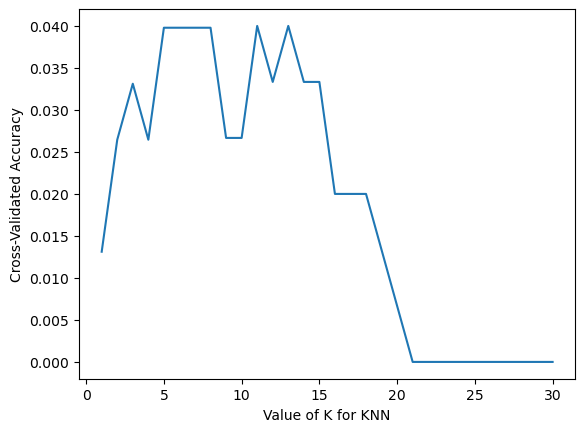

In [10]:
k_range = range(1, 31)

# list of scores from k_range
k_scores = []

# 1. we will loop through reasonable values of k
for k in k_range:
    # 2. run KNeighborsClassifier with k neighbours
    knn = KNeighborsClassifier(n_neighbors=k,algorithm='brute',p=2)
    # 3. obtain cross_val_score for KNeighborsClassifier with k neighbours
    scores = cross_val_score(knn, X_train, y_train[:], cv=5, scoring='accuracy')
    # 4. append mean of scores for k neighbors to k_scores list
    k_scores.append(scores.mean())

plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')
plt.show()


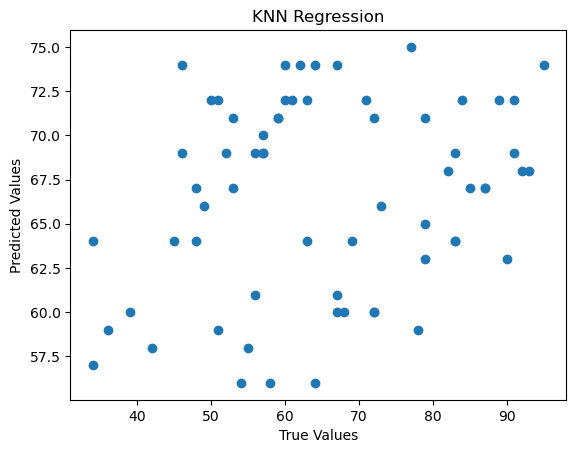

In [11]:
plt.scatter(y_test, yPred)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("KNN Regression")
plt.show()

Essentially KNN is a bad model to use here. It has given consistently low accuracy so we will instead try some other models

## Polynomial Regression with degree 1

In [12]:
X = pd.DataFrame(df, columns=['Teacher', 'Gender', 'Ethnic', 'Freeredu'])
y = pd.DataFrame(df, columns=['Score'])


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

poly = PolynomialFeatures(degree=1)
X_train = poly.fit_transform(X_train)
y_train = poly.fit_transform(y_train.reshape(-1,1))

X_test = poly.fit_transform(X_test)
y_test = poly.fit_transform(y_test.reshape(-1,1))

polyReg = LinearRegression()

polyReg.fit(X_train, y_train)
print(f'The training accuracy is: {polyReg.score(X_train, y_train)}')
print(f'The testing accuracy is: {polyReg.score(X_test, y_test)}')

The training accuracy is: 0.5835850088418695
The testing accuracy is: 0.5567871044864419


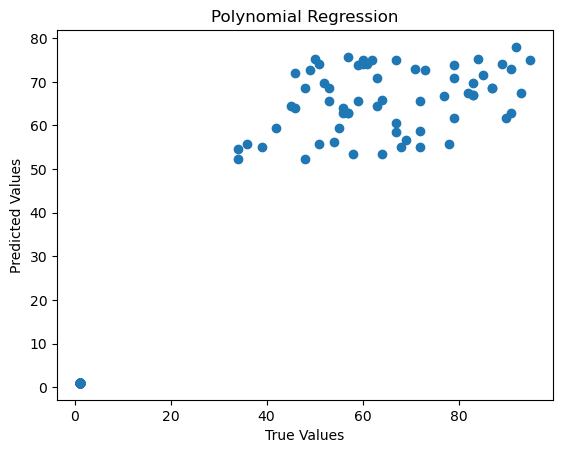

In [13]:
y_pred = polyReg.predict(X_test)
plt.scatter(y_test, y_pred)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Polynomial Regression")
plt.show()

### Make a dummy dataset to predict the scores for a bunch of students based on the polynomial regression model

We are going to make two different X matrices. One will be a group of students taught by Ruger. The other taught by Wesson. Both groups are the same students. 
In this group of students we will have 4 of each ethnicity. Within the 4 of an ethnicity two will be female and two will be male. One male and one female will come from a good socioeconomic background and the other two will not.

In [15]:
X_ruger = pd.read_csv('rugerStud.csv')
X_wesson = pd.read_csv('wessonStud.csv')
yPred_ruger = polyReg.predict(X_ruger)
yPred_wesson = polyReg.predict(X_wesson)


c:\Users\jerry\anaconda3\envs\python37\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
c:\Users\jerry\anaconda3\envs\python37\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [16]:
print(yPred_ruger[:,1].reshape(-1,1))


[[55.72970367]
 [62.80561822]
 [59.97155973]
 [57.42350525]
 [54.58944676]
 [61.66536131]
 [58.83130282]
 [56.28324834]
 [53.44918985]
 [60.5251044 ]
 [57.69104591]
 [55.14299143]
 [52.30893294]
 [59.38484749]
 [56.550789  ]]


In [17]:
print(yPred_wesson[:,1].reshape(-1,1))

[[63.89326704]
 [70.96918159]
 [68.1351231 ]
 [65.58706862]
 [62.75301013]
 [69.82892468]
 [66.99486619]
 [64.44681171]
 [61.61275322]
 [68.68866777]
 [65.85460928]
 [63.3065548 ]
 [60.47249631]
 [67.54841086]
 [64.71435237]]


## ANN

In [11]:
X = pd.DataFrame(df, columns=['Teacher', 'Gender', 'Ethnic', 'Freeredu'])
y = pd.DataFrame(df, columns=['Score'])


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# First we create the model for the ANN
model = Sequential()

# Now define the input layer and the hidden layer
model.add(Dense(units=2, input_dim=4, kernel_initializer='normal', activation='relu'))

# Finally connect the output layer 
model.add(Dense(1,kernel_initializer='normal'))

# Compile the model with MSE as loss
model.compile(loss='mean_squared_error',optimizer='adam')

# Fit to training set use a large number of epochs for example 40

model.fit(X_train,y_train,batch_size=20,epochs=50,verbose=0)


# Manual grid search
# Defining a function to find the best parameters for ANN
def FunctionFindBestParams(X_train, y_train, X_test, y_test):
    
    # Defining the list of hyper parameters to try
    batch_size_list=[5, 10, 15, 20]
    epoch_list  =   [5, 10, 50, 100]
    
    SearchResultsData=pd.DataFrame(columns=['TrialNumber', 'Parameters', 'Accuracy'])
    
    # initializing the trials
    TrialNumber=0
    for batch_size_trial in batch_size_list:
        for epochs_trial in epoch_list:
            TrialNumber+=1
            # Fitting the ANN to the Training set
            model.fit(X_train, y_train ,batch_size = batch_size_trial, epochs = epochs_trial, verbose=0)
 
            MAPE = np.mean(100 * (np.abs(y_test-model.predict(X_test))/y_test))
            
            # printing the results of the current iteration
            print(TrialNumber, 'Parameters:','batch_size:', batch_size_trial,'-', 'epochs:',epochs_trial, 'Accuracy:', 100-MAPE)
            
            SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, str(batch_size_trial)+'-'+str(epochs_trial), 100-MAPE]],
                                                                    columns=['TrialNumber', 'Parameters', 'Accuracy'] ))
    return(SearchResultsData)
 
 
# Calling the function
ResultsData=FunctionFindBestParams(X_train, y_train, X_test, y_test)
ResultsData


1 Parameters: batch_size: 5 - epochs: 5 Accuracy: Score    16.540346
dtype: float64
2 Parameters: batch_size: 5 - epochs: 10 Accuracy: Score    37.351504
dtype: float64
3 Parameters: batch_size: 5 - epochs: 50 Accuracy: Score    73.96127
dtype: float64
4 Parameters: batch_size: 5 - epochs: 100 Accuracy: Score    74.91319
dtype: float64
5 Parameters: batch_size: 10 - epochs: 5 Accuracy: Score    75.047876
dtype: float64
6 Parameters: batch_size: 10 - epochs: 10 Accuracy: Score    75.159138
dtype: float64
7 Parameters: batch_size: 10 - epochs: 50 Accuracy: Score    75.224344
dtype: float64
8 Parameters: batch_size: 10 - epochs: 100 Accuracy: Score    75.628002
dtype: float64
9 Parameters: batch_size: 15 - epochs: 5 Accuracy: Score    75.66109
dtype: float64
10 Parameters: batch_size: 15 - epochs: 10 Accuracy: Score    75.612639
dtype: float64
11 Parameters: batch_size: 15 - epochs: 50 Accuracy: Score    76.116568
dtype: float64
12 Parameters: batch_size: 15 - epochs: 100 Accuracy: Score 

TrialNumber Parameters                           Accuracy
0           1        5-5  Score    16.540346
dtype: float64
0           2       5-10  Score    37.351504
dtype: float64
0           3       5-50   Score    73.96127
dtype: float64
0           4      5-100   Score    74.91319
dtype: float64
0           5       10-5  Score    75.047876
dtype: float64
0           6      10-10  Score    75.159138
dtype: float64
0           7      10-50  Score    75.224344
dtype: float64
0           8     10-100  Score    75.628002
dtype: float64
0           9       15-5   Score    75.66109
dtype: float64
0          10      15-10  Score    75.612639
dtype: float64
0          11      15-50  Score    76.116568
dtype: float64
0          12     15-100  Score    76.143477
dtype: float64
0          13       20-5  Score    76.155659
dtype: float64
0          14      20-10  Score    76.151929
dtype: float64
0          15      20-50  Score    76.195441
dtype: float64
0          16     20-100  Score    76.354961
dtype: float64

According to the trials table, trial #4 with a batch size of 5 and epochs of 100 had the highest score. Therefore, batch_size=5 and epochs=100 were the chosen input.

In [15]:
X = pd.DataFrame(df, columns=['Teacher', 'Gender', 'Ethnic', 'Freeredu'])
y = pd.DataFrame(df, columns=['Score'])


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# Fit to training set use a large number of epochs for example 40

model.fit(X_train,y_train,batch_size=15,epochs=5,verbose=0)

In [16]:
# Separate Target Variable and Predictor Variables
TargetVariable=['Score']
Predictors=['Teacher', 'Gender', 'Ethnic', 'Freeredu']

# Generating Predictions on testing data
Predictions=model.predict(X_test)

# plotting some predictions vs the true values
TestingData=pd.DataFrame(data=X_test, columns=Predictors)
TestingData['Score']=y_test
TestingData['PredictedScore']=Predictions
TestingData

Teacher  Gender  Ethnic  Freeredu  Score  PredictedScore
201        2       1       3         1   79.0       65.955650
213        2       1       2         1   91.0       63.415707
138        3       0       4         1   71.0       81.269402
177        2       0       4         0   82.0       67.394112
15         1       1       4         0   68.0       54.620293
..       ...     ...     ...       ...    ...             ...
68         1       0       4         1   69.0       54.889496
5          1       1       3         1   58.0       52.765690
136        3       0       2         1   84.0       76.189537
56         1       1       4         0   72.0       54.620293
100        3       0       4         1   91.0       81.269402

[65 rows x 6 columns]

Here we can see that the ANN is performing decently well isn't very accurate. This may be improved if one-hot encoding was used for the categorical data instead of classes ranging from 1-n-1. 
Another interesting observation to note was that when a 2 layer neural net was used to predict, all of the predicted scores only varied by the 3rd decimal place. Once this layer was removed, we saw a significant increase in the prediction capabilities of the ANN. 